In [1]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns 

import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


#basic parameters
Features = 6
STEPS = 9
close_str = "close"
date_str  ='date'
time_series_split_qty = 5
training_error_measure_main = 'neg_mean_squared_error'

In [2]:
#9
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [3]:
#11
df = pd.read_csv('Bitfinex_ETHUSD_d.csv', skiprows=1, parse_dates=True, index_col=date_str)
df = df.sort_index().drop('symbol', axis=1)
#df.info()

Create STEP number of responses, these are the values of the stock x days in advance, which the day in question will be trained to predict 

In [4]:
#13-14
#create regressors
for i in np.arange(1 ,STEPS):
    col_name = '{}d_Fwd_Close'.format(i)
    df[col_name] = df[close_str].shift(-i)
    
df = df.dropna()

#split regressors and responses
Features = 6

X = df.iloc[:, :Features]
y = df.iloc[:, Features:]

split = int(len(df) * 0.7)

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

In [5]:
#17
def build_model(_alpha, _l1_ratio):
    estimator = ElasticNet(
        alpha=_alpha,
        l1_ratio=_l1_ratio,
        fit_intercept=True,
        #normalize=False,
        precompute=False,
        max_iter=16,
        copy_X=True,
        tol=0.1,
        warm_start=False,
        positive=False,
        random_state=None,
        selection='random'
    )

    return MultiOutputRegressor(estimator, n_jobs=4)

Time series splitter



In [6]:
#19
model = build_model(_alpha=1.0, _l1_ratio=0.3)
tscv = TimeSeriesSplit(n_splits=time_series_split_qty)
rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=tscv, scoring=training_error_measure_main))
R2 = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')

print(f"RMSE: {rmse.mean()} (+/- {rmse.std()}")
print(f"\nR2: {R2.mean()} (+/- {R2.std()}")

RMSE: 75538432.49962263 (+/- 150528540.9753079

R2: -2094600.5370076883 (+/- 4189186.619279579


Blocking time series splitter

In [7]:
#20
btscv = BlockingTimeSeriesSplit(n_splits=time_series_split_qty)
rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=btscv, scoring='neg_mean_squared_error'))
R2 = cross_val_score(model, X_train, y_train, cv=btscv, scoring='r2')

print(f"RMSE: {rmse.mean()} (+/- {rmse.std()}")
print(f"\nR2: {R2.mean()} (+/- {R2.std()}")

RMSE: 100303.64387989356 (+/- 92838.4950935872

R2: -0.7771238358332062 (+/- 1.3693119269045564


GridSearchCV

GridSearchCV works by exhaustively searching all the possible combinations of the model’s parameters

In [8]:
#21
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, best_params):
    
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title(f"Grid Search Best Params: {best_params}", fontsize=12, fontweight='medium')
    ax.set_xlabel(name_param_1, fontsize=12)
    ax.set_ylabel('CV Average Score', fontsize=12)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    ax.legend(bbox_to_anchor=(1.02, 1.02))

Time Series Spitter

In [9]:
#23 #24
params = {
    'estimator__alpha':(0.1, 0.3, 0.5, 0.7, 0.9),
    'estimator__l1_ratio':(0.1, 0.3, 0.5, 0.7, 0.9)
}

scores = []
for i in range(30):
    model = build_model(_alpha=1.0, _l1_ratio=0.3)

    finder = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='r2',
        n_jobs=4,
        #iid=False,
        refit=True,
        cv=tscv,  # change this to the splitter subject to test
        verbose=1,
        pre_dispatch=8,
        error_score=-999,
        return_train_score=True
        )

    finder.fit(X_train, y_train)

    best_params = finder.best_params_
    best_score = round(finder.best_score_,4)
    scores.append(best_score)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 

Blocking Time Series Splitter

In [10]:
#25
scores0 = []
for i in range(30):
    model = build_model(_alpha=1.0, _l1_ratio=0.3)
    
    finder0 = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='r2',
        n_jobs=4,
        #iid=False,
        refit=True,
        cv=btscv,  # change this to the splitter subject to test
        verbose=1,
        pre_dispatch=8,
        error_score=-999,
        return_train_score=True
        )

    finder0.fit(X_train, y_train)

    best_params0 = finder0.best_params_
    best_score0 = round(finder0.best_score_,4)
    scores0.append(best_score)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 

In [11]:
#26
finder0.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator__alpha', 'param_estimator__l1_ratio', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [12]:
#29
preds = pd.DataFrame(finder.predict(X_test), columns=df.iloc[:, Features:].columns)
preds.head()

,Volume ETH,1d_Fwd_Close,2d_Fwd_Close,3d_Fwd_Close,4d_Fwd_Close,5d_Fwd_Close,6d_Fwd_Close,7d_Fwd_Close,8d_Fwd_Close
0,165653.589455,1588.406873,1701.476381,1571.519454,1714.007926,1715.074286,1569.562099,1673.802433,1640.062488
1,423200.178317,1670.905756,1643.953077,1817.997255,1658.008500,1662.341136,1785.093163,1763.858740,1746.272238
2,236039.541876,1827.388652,1783.098231,1755.302732,1794.699307,1793.744350,1745.418002,1800.513295,1825.755884
3,159505.497499,1792.758734,1798.451619,1696.024826,1808.623648,1807.339657,1681.745274,1812.045192,1804.894922
4,-109582.963909,1821.395193,1766.453111,1572.285055,1767.822638,1763.254604,1496.365801,1792.708801,1768.816632


C:\Users\Fabio\AppData\Local\Temp\ipykernel_12336\2359456239.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[split:].index.strftime('%Y-%m-%d'))


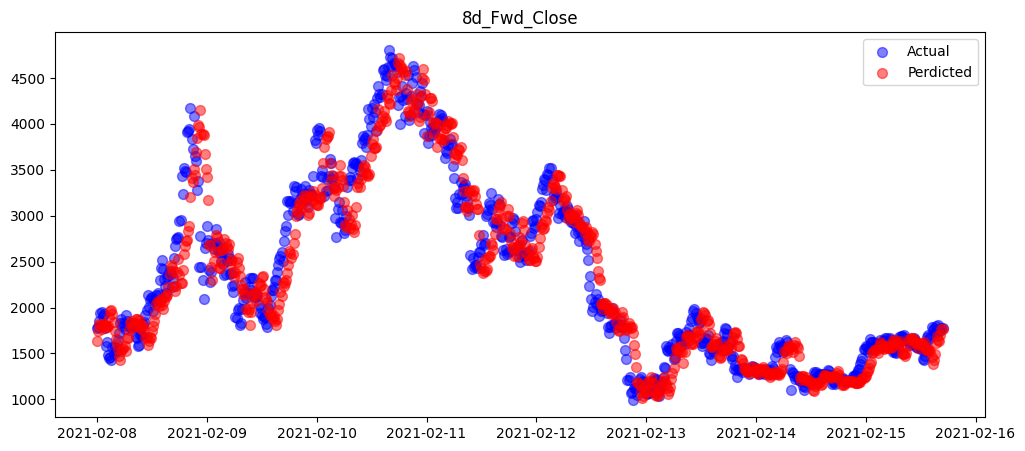

In [13]:
#30
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(preds.index, y_test['8d_Fwd_Close'], color='b', alpha=0.5, label='Actual', s=50)
ax.scatter(preds.index, preds['8d_Fwd_Close'], color='r', alpha=0.5, label='Perdicted', s=50)
ax.set_xticklabels(df[split:].index.strftime('%Y-%m-%d'))
ax.set_title('8d_Fwd_Close')
ax.legend()
plt.show()

After obtaining the optimal values for the models parameters, we can train the model and evaluate it on the testing set. The results, as depicted in the plot above, indicate smooth capture of the trend and minimum error rate.

In [14]:
#31
model = build_model(_alpha=1.0, _l1_ratio=0.3)
rmse = np.sqrt(-cross_val_score(model, X_test, y_test, cv=tscv, scoring='neg_mean_squared_error'))

mae =         cross_val_score(model, X_test, y_test, cv=tscv, scoring="neg_mean_absolute_error")

R2 = cross_val_score(model, X_test, y_test, cv=tscv, scoring='r2')

print(f"RMSE: {rmse.mean()} (+/- {rmse.std()}")
print(f"\nmae: {mae.mean()} (+/- {mae.std()}")
print(f"\nR2: {R2.mean()} (+/- {R2.std()}")

RMSE: 7681.06941558288 (+/- 3623.5548732942

mae: -2894.5855312781964 (+/- 1114.2735223987881

R2: 0.4034905379216326 (+/- 0.5324890981062943


C:\Users\Fabio\AppData\Local\Temp\ipykernel_12336\1479406149.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[split:].index.strftime('%Y-%m-%d'))


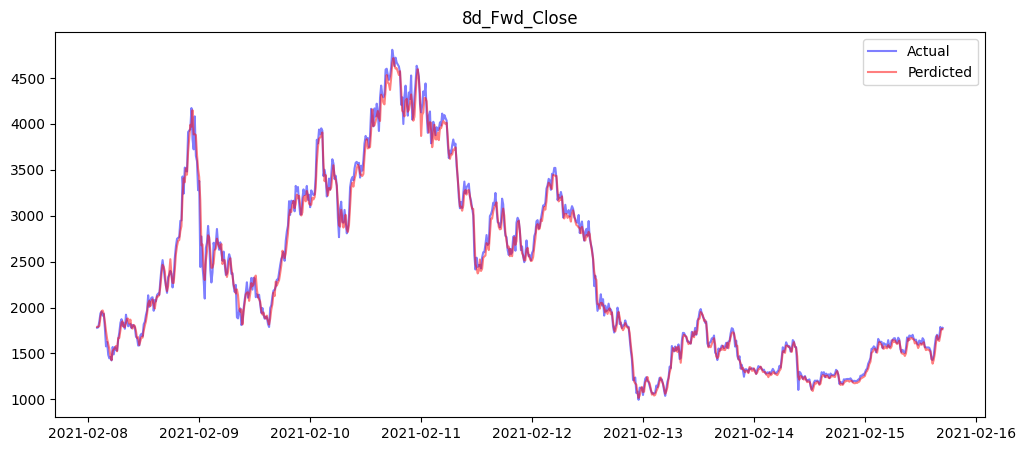

In [15]:
preds_FG  = preds[8:]
y_test_FG = y_test[:-8]


fig, ax = plt.subplots(figsize=(12,5))
#ax.plot(preds_FG.index, y_test_FG['8d_Fwd_Close'], color='b', alpha=0.5, label='Actual', s=50)
#ax.plot(preds_FG.index, preds_FG['8d_Fwd_Close'], color='r', alpha=0.5, label='Perdicted', s=50)
ax.plot(preds_FG.index, y_test_FG['8d_Fwd_Close'], color='b', alpha=0.5, label='Actual')
ax.plot(preds_FG.index, preds_FG['8d_Fwd_Close'], color='r', alpha=0.5, label='Perdicted')
ax.set_xticklabels(df[split:].index.strftime('%Y-%m-%d'))
ax.set_title('8d_Fwd_Close')
ax.legend()
plt.show()


